<a href="https://colab.research.google.com/github/balados85/deep-learning-brain-mri-classification/blob/main/EfficientNetKerasv0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A larger part of this code was adapted from Yixing Fu's project on google colab. The build_model, unreeze and plot_hist functions were adapted and tweaked appropriately for this project** [Find original code here.](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/image_classification_efficientnet_fine_tuning.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pillow

In [ ]:
!pip install cloud_tpu_client

     |████████████████████████████████| 57 kB 2.7 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.278 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow import keras
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
from tensorflow.keras.applications import EfficientNetB1
model = EfficientNetB1(weights=None)
import PIL.Image
import pathlib


In [ ]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
batch_size = 4
IMG_SIZE = 240
original_dataset_dir = 'drive/MyDrive/mri_images/train'

In [ ]:
data_dir = pathlib.Path(original_dataset_dir)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 2552 files belonging to 3 classes.
Using 2042 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 2552 files belonging to 3 classes.
Using 510 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
NUM_CLASSES = int(3)


['0', '1', '2']


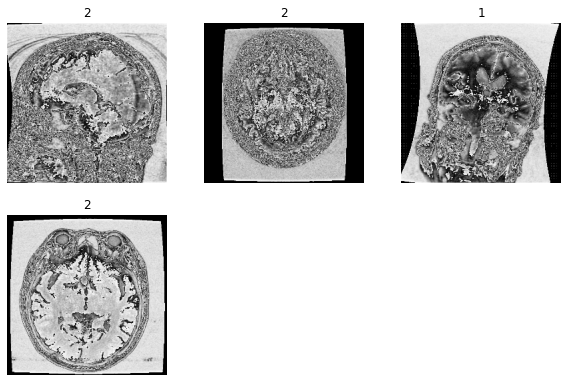

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"),cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(4, 240, 240, 3)
(4,)


In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

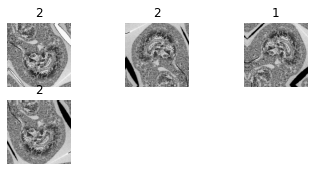

In [ ]:
for image, label in train_ds.take(1):
    for i in range(4):
        aug_img = img_augmentation(image)
        ax = plt.subplot(3, 3, i + 1)
        
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB1(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

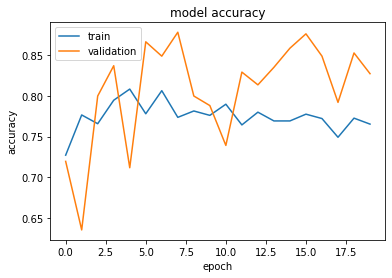

This image most likely belongs to 0 with a 55.48 percent confidence.


In [ ]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

    epochs = 20  # @param {type: "slider", min:8, max:80}
    hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)


plot_hist(hist)

img = keras.preprocessing.image.load_img(
    "drive/MyDrive/mri_images/test/1/1.png", target_size=(IMG_SIZE,IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_ds.class_names[np.argmax(score)], 100 * np.max(score))
) 

Epoch 1/50
511/511 - 48s - loss: 0.5455 - accuracy: 0.8183 - val_loss: 0.3182 - val_accuracy: 0.8882
Epoch 2/50
511/511 - 31s - loss: 0.4568 - accuracy: 0.8404 - val_loss: 0.2691 - val_accuracy: 0.9000
Epoch 3/50
511/511 - 31s - loss: 0.4623 - accuracy: 0.8374 - val_loss: 0.2443 - val_accuracy: 0.9078
Epoch 4/50
511/511 - 31s - loss: 0.4373 - accuracy: 0.8531 - val_loss: 0.1993 - val_accuracy: 0.9412
Epoch 5/50
511/511 - 31s - loss: 0.3872 - accuracy: 0.8614 - val_loss: 0.2052 - val_accuracy: 0.9353
Epoch 6/50
511/511 - 31s - loss: 0.3570 - accuracy: 0.8805 - val_loss: 0.2163 - val_accuracy: 0.9314
Epoch 7/50
511/511 - 30s - loss: 0.3959 - accuracy: 0.8575 - val_loss: 0.1977 - val_accuracy: 0.9510
Epoch 8/50
511/511 - 31s - loss: 0.3785 - accuracy: 0.8678 - val_loss: 0.1894 - val_accuracy: 0.9373
Epoch 9/50
511/511 - 31s - loss: 0.3453 - accuracy: 0.8844 - val_loss: 0.1879 - val_accuracy: 0.9333
Epoch 10/50
511/511 - 31s - loss: 0.3562 - accuracy: 0.8790 - val_loss: 0.1677 - val_accura

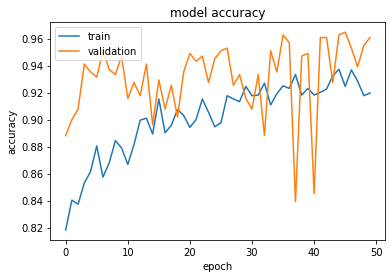

This image most likely belongs to 1 with a 56.83 percent confidence.


In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 50  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)

img = keras.preprocessing.image.load_img(
    "drive/MyDrive/mri_images/test/1/1.png", target_size=(IMG_SIZE,IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(train_ds.class_names[np.argmax(score)], 100 * np.max(score))
)



In [ ]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 240, 240, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 240, 240, 3)  0           img_augmentation[0][0]           
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 240, 240, 3)  7           rescaling_1[0][0]                
_______________________________________________________________________________________